In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
%matplotlib inline

In [7]:
# load positive labels
pos = open('Dataset/Positive_tweets(10000).csv').read()
npos = 0
labels, texts = [], []
for i, line in enumerate(pos.split("\n")):
    content = line.split(',')
    if len(content) < 4:
    	continue;
    if content[4] != "English":
    	continue;
    labels.append(1)
    texts.append(content[2])
    npos += 1

# load negative labels (random tweets)
neg = open('Dataset/Negative_tweets(10000).txt').read()
nneg = 0
for i, line in enumerate(neg.split("\n")):
    labels.append(0)
    texts.append(line)
    nneg += 1

texts, labels = shuffle(texts, labels)

print('Total number of datapoints: ', len(labels))
print('Positive labels: ', npos)
print('Negative labels: ', nneg)

df = pd.DataFrame()
df['text'] = texts
df['label'] = labels

df.head()

Total number of datapoints:  12514
Positive labels:  4541
Negative labels:  7973


,text,label
0,@seanhannity @FoxNews @foxandfriends LOL!!! Cl...,0
1,"""""""Juss no law in #US at all"""" - @Blkhysteria""",1
2,'@AFRICAisMankind @4mysquad @BlackjediNow @foo...,1
3,Think of 'The Producers' with Trump as Max; hi...,0
4,Did Trump have a fiduciary duty to these folks...,0


Text(0.5, 1.0, 'Breakdown by label type')

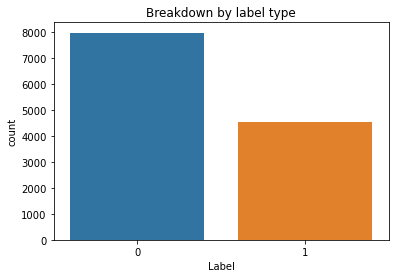

In [8]:
sns.countplot(df.label)
plt.xlabel('Label')
plt.title('Breakdown by label type')

In [9]:
enc = LabelEncoder()
y = enc.fit_transform(labels).reshape(-1,1)
train_x, test_x, train_y, test_y = train_test_split(df['text'], y, test_size=0.20)

# Tokenize the text. Max length 280 (may tweak)

maxlen = 280
maxwords = 10000

token = Tokenizer(num_words=maxwords)
token.fit_on_texts(df['text'])

sequences = token.texts_to_sequences(train_x)
padded = sequence.pad_sequences(sequences, maxlen=maxlen)

In [17]:
def lstm_model():
    inputs = Input(name='inputs',shape=[maxlen])
    layer = Embedding(maxwords,50,input_length=maxlen)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = lstm_model()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 280)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 280, 50)           500000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [18]:
history = model.fit(padded,train_y,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
251/251 [==============================] - 35s 117ms/step - loss: 0.4101 - accuracy: 0.7897 - val_loss: 0.1251 - val_accuracy: 0.9496
Epoch 2/10
251/251 [==============================] - 25s 101ms/step - loss: 0.0940 - accuracy: 0.9661 - val_loss: 0.0997 - val_accuracy: 0.9576
Epoch 3/10
251/251 [==============================] - 29s 116ms/step - loss: 0.0694 - accuracy: 0.9747 - val_loss: 0.0954 - val_accuracy: 0.9670
Epoch 4/10
251/251 [==============================] - 36s 145ms/step - loss: 0.0585 - accuracy: 0.9818 - val_loss: 0.1084 - val_accuracy: 0.9566


In [19]:
test_sequences = token.texts_to_sequences(test_x)
test_padded = sequence.pad_sequences(test_sequences,maxlen=maxlen)

accuracy = model.evaluate(test_padded, test_y)
print('Test loss: ', accuracy[0])
print('Test accuracy: ', accuracy[1])



79/79 [==============================] - 2s 29ms/step - loss: 0.1166 - accuracy: 0.9608
Test loss:  0.11664967983961105
Test accuracy:  0.9608469605445862


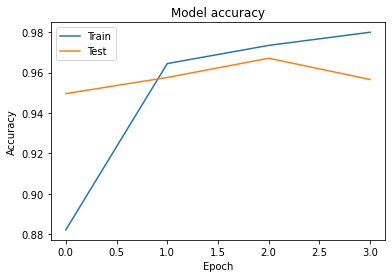

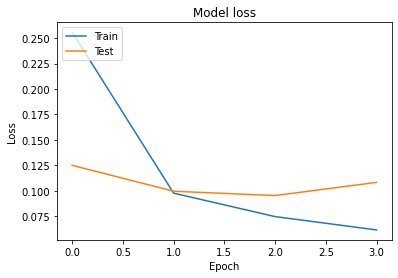

In [21]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()